### Data Dictionary

We have downloaded a fuel consumption dataset, **`FuelConsumption.csv`**, which contains model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada.

- **MODELYEAR** e.g. 2014
- **MAKE** e.g. Acura
- **MODEL** e.g. ILX
- **VEHICLE CLASS** e.g. SUV
- **ENGINE SIZE** e.g. 4.7
- **CYLINDERS** e.g 6
- **TRANSMISSION** e.g. A6
- **FUELTYPE** e.g. z
- **FUEL CONSUMPTION in CITY(L/100 km)** e.g. 9.9
- **FUEL CONSUMPTION in HWY (L/100 km)** e.g. 8.9
- **FUEL CONSUMPTION COMB (L/100 km)** e.g. 9.2
- **CO2 EMISSIONS (g/km)** e.g. 182   --> low --> 0

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.25)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

from tpot import TPOTClassifier, TPOTRegressor

import warnings
warnings.filterwarnings('ignore')


pd.options.display.max_columns= None
#pd.options.display.max_rows = None

### Data Exploration

In [2]:
df = pd.read_csv("FuelConsumption.csv")

In [3]:
df

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,2014,VOLVO,XC60 AWD,SUV - SMALL,3.0,6,AS6,X,13.4,9.8,11.8,24,271
1063,2014,VOLVO,XC60 AWD,SUV - SMALL,3.2,6,AS6,X,13.2,9.5,11.5,25,264
1064,2014,VOLVO,XC70 AWD,SUV - SMALL,3.0,6,AS6,X,13.4,9.8,11.8,24,271
1065,2014,VOLVO,XC70 AWD,SUV - SMALL,3.2,6,AS6,X,12.9,9.3,11.3,25,260


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MODELYEAR                 1067 non-null   int64  
 1   MAKE                      1067 non-null   object 
 2   MODEL                     1067 non-null   object 
 3   VEHICLECLASS              1067 non-null   object 
 4   ENGINESIZE                1067 non-null   float64
 5   CYLINDERS                 1067 non-null   int64  
 6   TRANSMISSION              1067 non-null   object 
 7   FUELTYPE                  1067 non-null   object 
 8   FUELCONSUMPTION_CITY      1067 non-null   float64
 9   FUELCONSUMPTION_HWY       1067 non-null   float64
 10  FUELCONSUMPTION_COMB      1067 non-null   float64
 11  FUELCONSUMPTION_COMB_MPG  1067 non-null   int64  
 12  CO2EMISSIONS              1067 non-null   int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 108.5+ KB


In [5]:
df.describe(include='all')

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
count,1067.0,1067,1067,1067,1067.000000,1067.000000,1067,1067,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
unique,NaN,39,663,16,NaN,NaN,22,4,NaN,NaN,NaN,NaN,NaN
top,NaN,FORD,F150 FFV,MID-SIZE,NaN,NaN,A6,X,NaN,NaN,NaN,NaN,NaN
freq,NaN,90,8,178,NaN,NaN,222,514,NaN,NaN,NaN,NaN,NaN
mean,2014.0,NaN,NaN,NaN,3.346298,5.794752,NaN,NaN,13.296532,9.474602,11.580881,26.441425,256.228679
std,0.0,NaN,NaN,NaN,1.415895,1.797447,NaN,NaN,4.101253,2.794510,3.485595,7.468702,63.372304
min,2014.0,NaN,NaN,NaN,1.000000,3.000000,NaN,NaN,4.600000,4.900000,4.700000,11.000000,108.000000
25%,2014.0,NaN,NaN,NaN,2.000000,4.000000,NaN,NaN,10.250000,7.500000,9.000000,21.000000,207.000000
50%,2014.0,NaN,NaN,NaN,3.400000,6.000000,NaN,NaN,12.600000,8.800000,10.900000,26.000000,251.000000
75%,2014.0,NaN,NaN,NaN,4.300000,8.000000,NaN,NaN,15.550000,10.850000,13.350000,31.000000,294.000000


In [6]:
df.shape

(1067, 13)

In [7]:
df.columns

Index(['MODELYEAR', 'MAKE', 'MODEL', 'VEHICLECLASS', 'ENGINESIZE', 'CYLINDERS',
       'TRANSMISSION', 'FUELTYPE', 'FUELCONSUMPTION_CITY',
       'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB',
       'FUELCONSUMPTION_COMB_MPG', 'CO2EMISSIONS'],
      dtype='object')

### Data Visualization

### Univariate Data Exploration

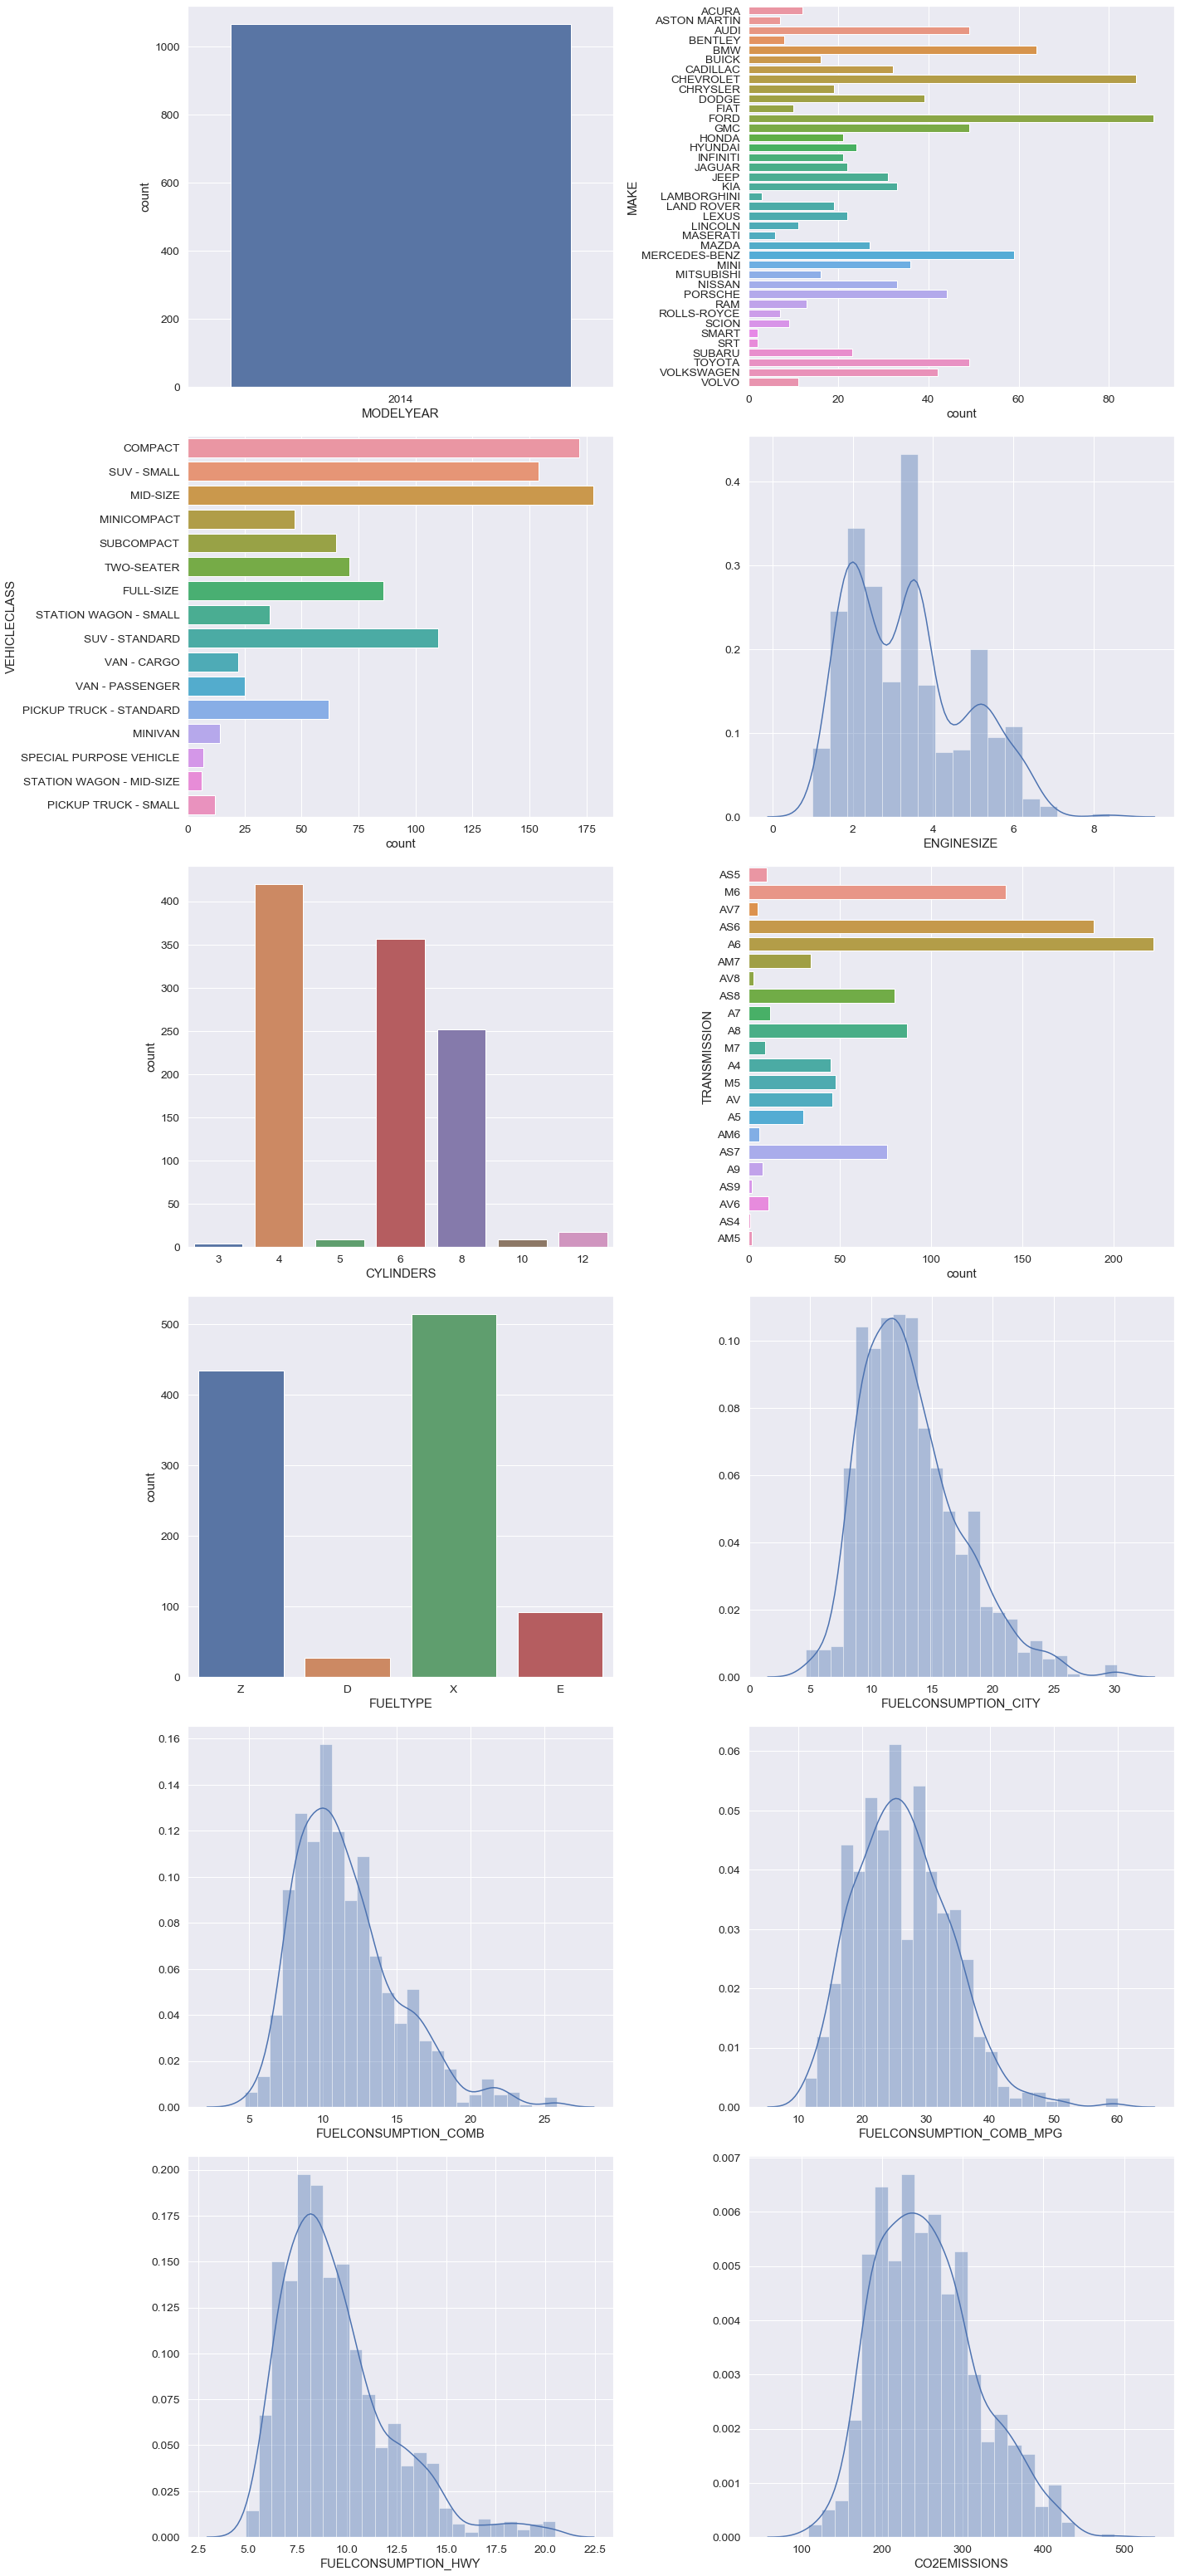

In [8]:
fig = plt.figure(figsize=(20,50))

plt.subplot(7,2,1)
sns.countplot(df.MODELYEAR)
plt.subplot(7,2,2)
sns.countplot(y = df.MAKE)
plt.subplot(7,2,3)
sns.countplot(y = df.VEHICLECLASS)
plt.subplot(7,2,4)
sns.distplot(df.ENGINESIZE)
plt.subplot(7,2,5)
sns.countplot(df.CYLINDERS)
plt.subplot(7,2,6)
sns.countplot(y = df.TRANSMISSION)
plt.subplot(7,2,7)
sns.countplot(df.FUELTYPE)
plt.subplot(7,2,8)
sns.distplot(df.FUELCONSUMPTION_CITY)
plt.subplot(7,2,9)
sns.distplot(df.FUELCONSUMPTION_COMB)
plt.subplot(7,2,10)
sns.distplot(df.FUELCONSUMPTION_COMB_MPG)
plt.subplot(7,2,11)
sns.distplot(df.FUELCONSUMPTION_HWY)
plt.subplot(7,2,12)
sns.distplot(df.CO2EMISSIONS)
# plt.subplot(7,2,13)
# sns.countplot()
# plt.subplot(7,2,14)
# sns.countplot()

plt.tight_layout()
plt.show()

### Bivariate Data Exploration

In [9]:
df.columns

Index(['MODELYEAR', 'MAKE', 'MODEL', 'VEHICLECLASS', 'ENGINESIZE', 'CYLINDERS',
       'TRANSMISSION', 'FUELTYPE', 'FUELCONSUMPTION_CITY',
       'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB',
       'FUELCONSUMPTION_COMB_MPG', 'CO2EMISSIONS'],
      dtype='object')

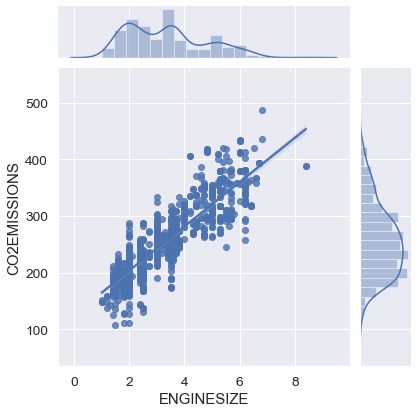

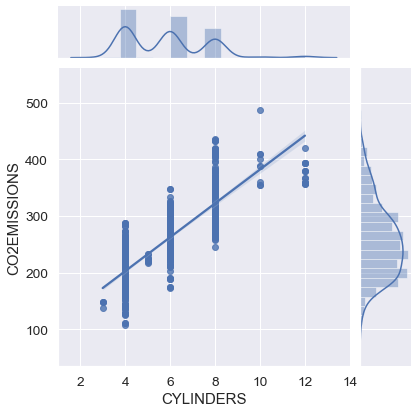

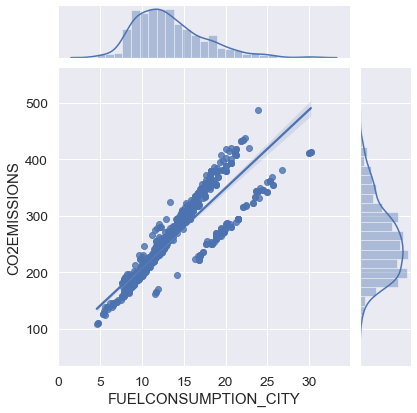

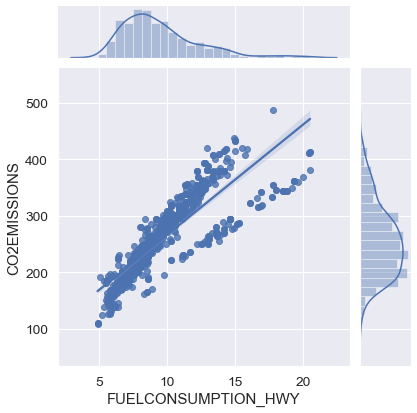

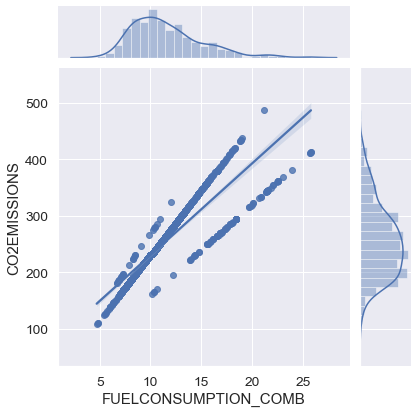

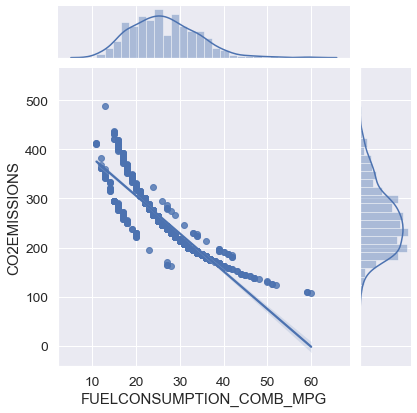

In [10]:
sns.jointplot(x='ENGINESIZE', y='CO2EMISSIONS',data=df, kind='reg')

sns.jointplot(x='CYLINDERS', y='CO2EMISSIONS',data=df, kind='reg')

sns.jointplot(x='FUELCONSUMPTION_CITY', y='CO2EMISSIONS',data=df, kind='reg')

sns.jointplot(x='FUELCONSUMPTION_HWY', y='CO2EMISSIONS',data=df, kind='reg')

sns.jointplot(x='FUELCONSUMPTION_COMB', y='CO2EMISSIONS',data=df, kind='reg')

sns.jointplot(x='FUELCONSUMPTION_COMB_MPG', y='CO2EMISSIONS',data=df, kind='reg')


plt.show()

In [11]:
df.corr()

,MODELYEAR,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
MODELYEAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENGINESIZE,NaN,1.000000,0.934011,0.832225,0.778746,0.819482,-0.808554,0.874154
CYLINDERS,NaN,0.934011,1.000000,0.796473,0.724594,0.776788,-0.770430,0.849685
FUELCONSUMPTION_CITY,NaN,0.832225,0.796473,1.000000,0.965718,0.995542,-0.935613,0.898039
FUELCONSUMPTION_HWY,NaN,0.778746,0.724594,0.965718,1.000000,0.985804,-0.893809,0.861748
FUELCONSUMPTION_COMB,NaN,0.819482,0.776788,0.995542,0.985804,1.000000,-0.927965,0.892129
FUELCONSUMPTION_COMB_MPG,NaN,-0.808554,-0.770430,-0.935613,-0.893809,-0.927965,1.000000,-0.906394
CO2EMISSIONS,NaN,0.874154,0.849685,0.898039,0.861748,0.892129,-0.906394,1.000000


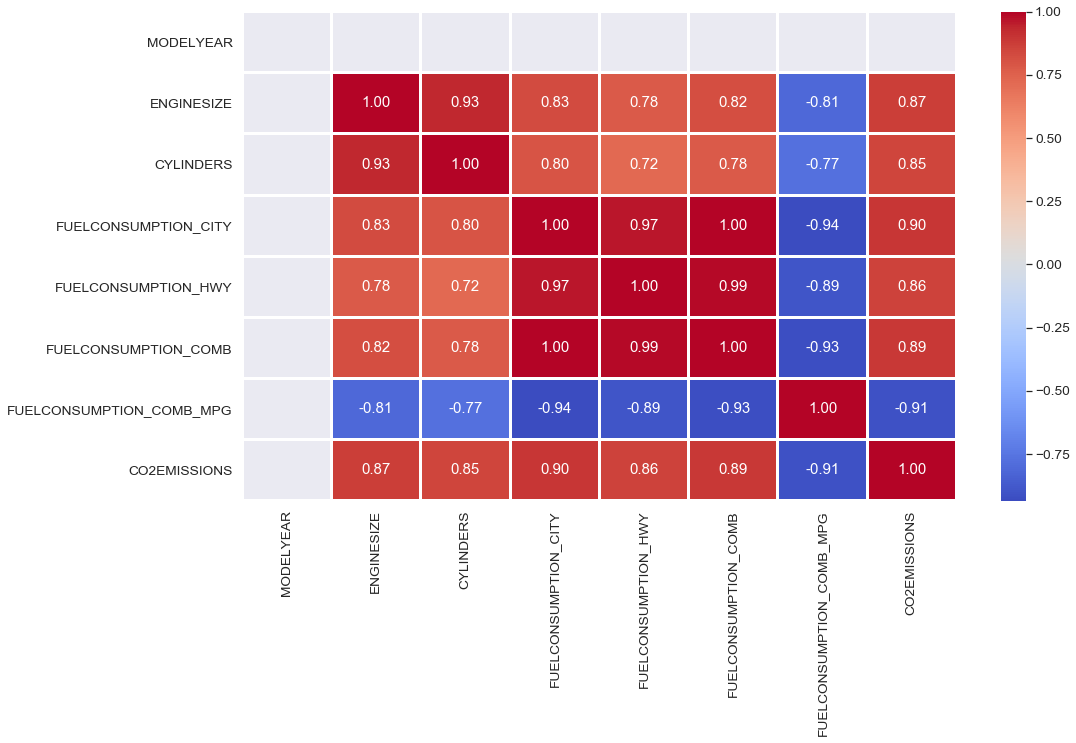

In [12]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

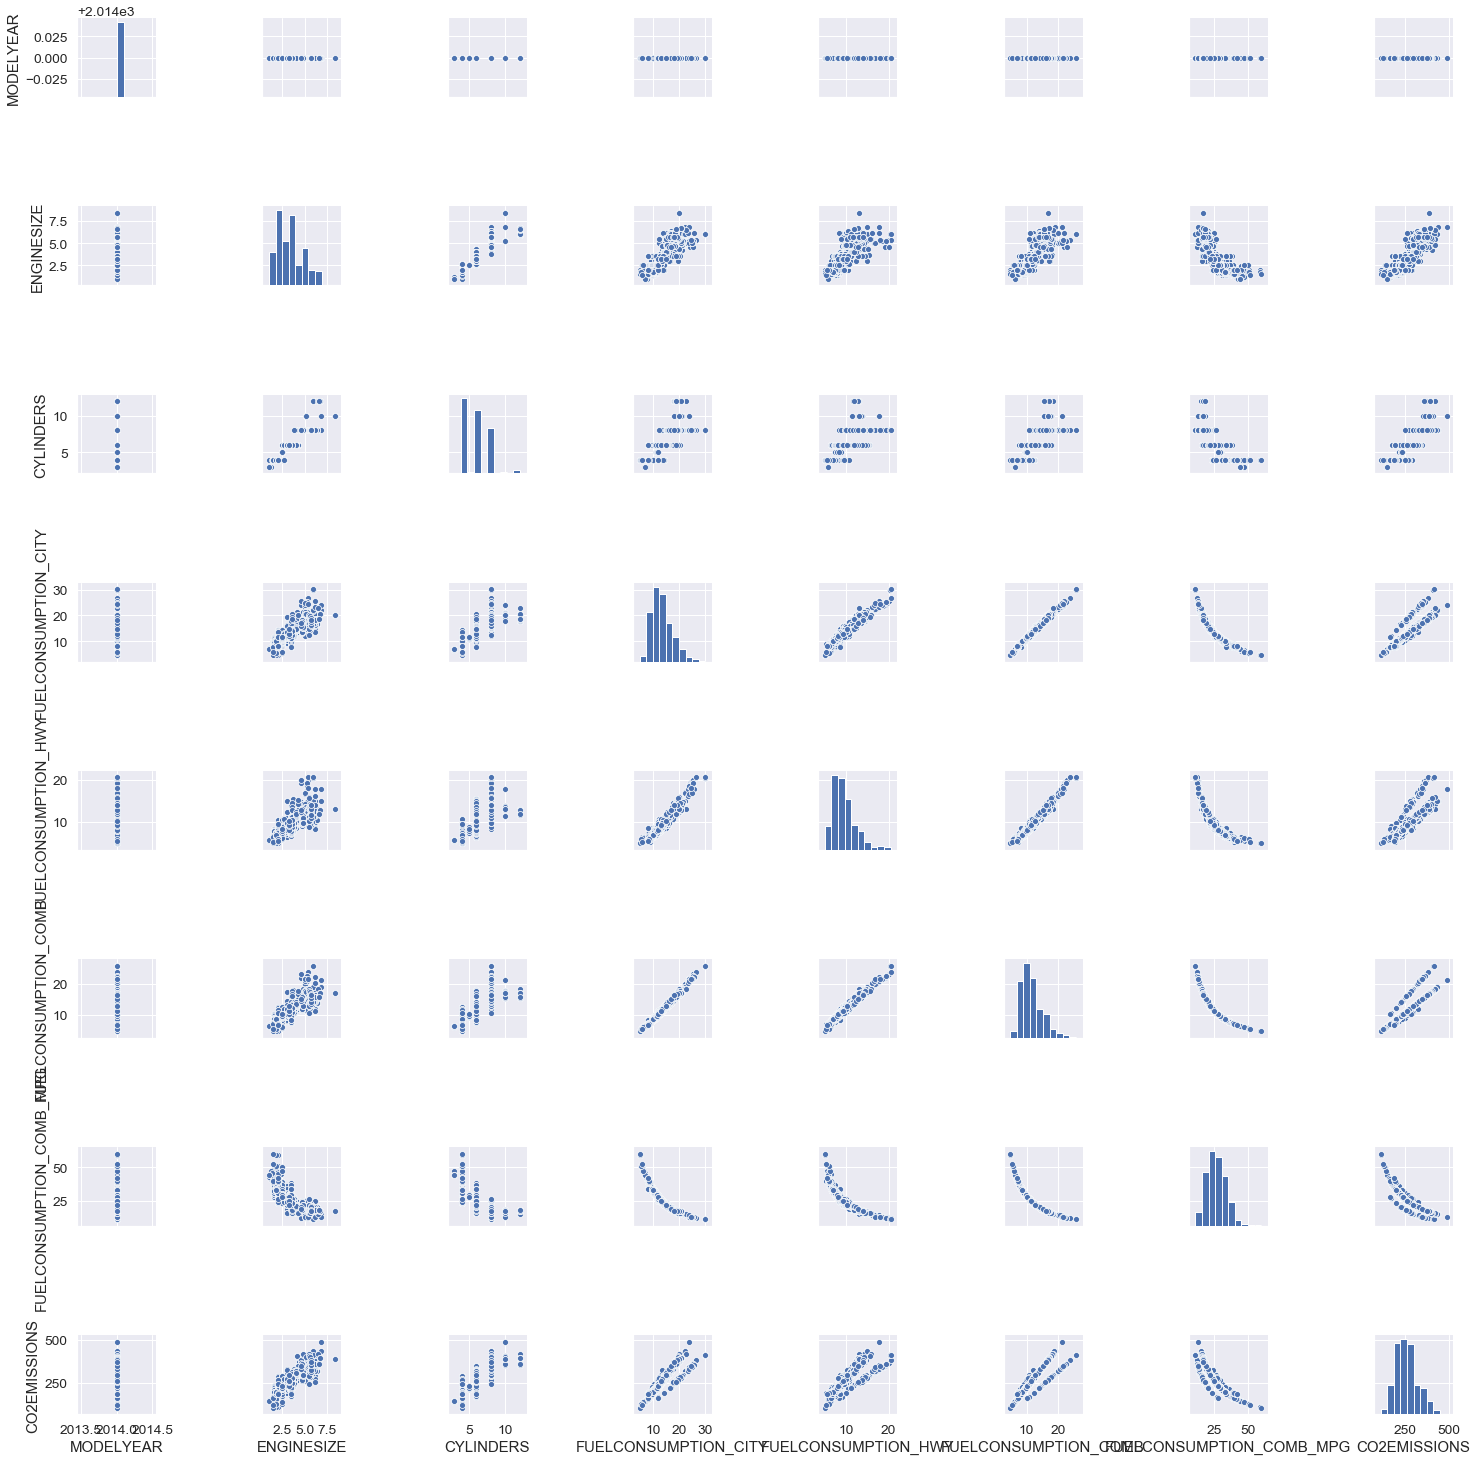

In [13]:
sns.pairplot(df)
plt.show()

### Data Preprocessing

### Treat Missing Values

In [14]:
df.isnull().sum()

MODELYEAR                   0
MAKE                        0
MODEL                       0
VEHICLECLASS                0
ENGINESIZE                  0
CYLINDERS                   0
TRANSMISSION                0
FUELTYPE                    0
FUELCONSUMPTION_CITY        0
FUELCONSUMPTION_HWY         0
FUELCONSUMPTION_COMB        0
FUELCONSUMPTION_COMB_MPG    0
CO2EMISSIONS                0
dtype: int64

### Treat Duplicate Values

In [15]:
df.duplicated(keep='first').sum()

0

### Treat Imbalance Data

### Treat Outliers

### Treat Data Types

### Drop unwanted features

In [16]:
df.columns

Index(['MODELYEAR', 'MAKE', 'MODEL', 'VEHICLECLASS', 'ENGINESIZE', 'CYLINDERS',
       'TRANSMISSION', 'FUELTYPE', 'FUELCONSUMPTION_CITY',
       'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB',
       'FUELCONSUMPTION_COMB_MPG', 'CO2EMISSIONS'],
      dtype='object')

In [17]:
df.drop(['MODELYEAR', 'MAKE', 'MODEL','VEHICLECLASS','TRANSMISSION'],axis=1,inplace=True)

In [18]:
df

,ENGINESIZE,CYLINDERS,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2.0,4,Z,9.9,6.7,8.5,33,196
1,2.4,4,Z,11.2,7.7,9.6,29,221
2,1.5,4,Z,6.0,5.8,5.9,48,136
3,3.5,6,Z,12.7,9.1,11.1,25,255
4,3.5,6,Z,12.1,8.7,10.6,27,244
...,...,...,...,...,...,...,...,...
1062,3.0,6,X,13.4,9.8,11.8,24,271
1063,3.2,6,X,13.2,9.5,11.5,25,264
1064,3.0,6,X,13.4,9.8,11.8,24,271
1065,3.2,6,X,12.9,9.3,11.3,25,260


In [19]:
df2 = pd.get_dummies(df,columns=['FUELTYPE'],drop_first=True)

In [20]:
df2

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS,FUELTYPE_E,FUELTYPE_X,FUELTYPE_Z
0,2.0,4,9.9,6.7,8.5,33,196,0,0,1
1,2.4,4,11.2,7.7,9.6,29,221,0,0,1
2,1.5,4,6.0,5.8,5.9,48,136,0,0,1
3,3.5,6,12.7,9.1,11.1,25,255,0,0,1
4,3.5,6,12.1,8.7,10.6,27,244,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1062,3.0,6,13.4,9.8,11.8,24,271,0,1,0
1063,3.2,6,13.2,9.5,11.5,25,264,0,1,0
1064,3.0,6,13.4,9.8,11.8,24,271,0,1,0
1065,3.2,6,12.9,9.3,11.3,25,260,0,1,0


In [21]:
df2.columns

Index(['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_CITY',
       'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB',
       'FUELCONSUMPTION_COMB_MPG', 'CO2EMISSIONS', 'FUELTYPE_E', 'FUELTYPE_X',
       'FUELTYPE_Z'],
      dtype='object')

In [22]:
df2 = df2[['ENGINESIZE', 'CYLINDERS','FUELCONSUMPTION_CITY','FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB',
       'FUELCONSUMPTION_COMB_MPG','FUELTYPE_E', 'FUELTYPE_X','FUELTYPE_Z','CO2EMISSIONS']]

In [23]:
df2

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,FUELTYPE_E,FUELTYPE_X,FUELTYPE_Z,CO2EMISSIONS
0,2.0,4,9.9,6.7,8.5,33,0,0,1,196
1,2.4,4,11.2,7.7,9.6,29,0,0,1,221
2,1.5,4,6.0,5.8,5.9,48,0,0,1,136
3,3.5,6,12.7,9.1,11.1,25,0,0,1,255
4,3.5,6,12.1,8.7,10.6,27,0,0,1,244
...,...,...,...,...,...,...,...,...,...,...
1062,3.0,6,13.4,9.8,11.8,24,0,1,0,271
1063,3.2,6,13.2,9.5,11.5,25,0,1,0,264
1064,3.0,6,13.4,9.8,11.8,24,0,1,0,271
1065,3.2,6,12.9,9.3,11.3,25,0,1,0,260


### Create and save processed dataset

In [24]:
#df2.to_csv("fueltrain.csv",index=False)

In [25]:
df2.shape

(1067, 10)

### Train Test Split

In [26]:
X = df2.iloc[:,0:9]
y = df2.iloc[:,9]

In [27]:
X.values, y.values

(array([[ 2. ,  4. ,  9.9, ...,  0. ,  0. ,  1. ],
        [ 2.4,  4. , 11.2, ...,  0. ,  0. ,  1. ],
        [ 1.5,  4. ,  6. , ...,  0. ,  0. ,  1. ],
        ...,
        [ 3. ,  6. , 13.4, ...,  0. ,  1. ,  0. ],
        [ 3.2,  6. , 12.9, ...,  0. ,  1. ,  0. ],
        [ 3.2,  6. , 14.9, ...,  0. ,  1. ,  0. ]]),
 array([196, 221, 136, ..., 271, 260, 294], dtype=int64))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((853, 9), (214, 9), (853,), (214,))

### Feature Scaling

### Model Training

### Using XGBoost

In [30]:
xgbmodel = XGBRegressor(random_state=0, n_estimators=1500, objective='reg:squarederror')

In [31]:
xgbmodel.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='rmse',early_stopping_rounds=20)

[0]	validation_0-rmse:232.85
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:209.521
[2]	validation_0-rmse:188.55
[3]	validation_0-rmse:169.664
[4]	validation_0-rmse:152.804
[5]	validation_0-rmse:137.454
[6]	validation_0-rmse:123.727
[7]	validation_0-rmse:111.293
[8]	validation_0-rmse:100.279
[9]	validation_0-rmse:90.2583
[10]	validation_0-rmse:81.2742
[11]	validation_0-rmse:73.2843
[12]	validation_0-rmse:66.0502
[13]	validation_0-rmse:59.5416
[14]	validation_0-rmse:53.6149
[15]	validation_0-rmse:48.3039
[16]	validation_0-rmse:43.5674
[17]	validation_0-rmse:39.2207
[18]	validation_0-rmse:35.3327
[19]	validation_0-rmse:31.8826
[20]	validation_0-rmse:28.8484
[21]	validation_0-rmse:26.056
[22]	validation_0-rmse:23.5578
[23]	validation_0-rmse:21.3317
[24]	validation_0-rmse:19.3455
[25]	validation_0-rmse:17.5631
[26]	validation_0-rmse:16.0125
[27]	validation_0-rmse:14.6366
[28]	validation_0-rmse:13.3872
[29]	validation_0-rmse:12.2735
[30]	validation_0-

[259]	validation_0-rmse:2.90832
[260]	validation_0-rmse:2.90901
[261]	validation_0-rmse:2.9085
[262]	validation_0-rmse:2.90562
[263]	validation_0-rmse:2.90227
[264]	validation_0-rmse:2.90183
[265]	validation_0-rmse:2.90261
[266]	validation_0-rmse:2.90017
[267]	validation_0-rmse:2.88379
[268]	validation_0-rmse:2.87834
[269]	validation_0-rmse:2.86793
[270]	validation_0-rmse:2.86648
[271]	validation_0-rmse:2.86562
[272]	validation_0-rmse:2.86701
[273]	validation_0-rmse:2.86576
[274]	validation_0-rmse:2.86381
[275]	validation_0-rmse:2.86312
[276]	validation_0-rmse:2.85364
[277]	validation_0-rmse:2.85108
[278]	validation_0-rmse:2.84816
[279]	validation_0-rmse:2.84732
[280]	validation_0-rmse:2.84527
[281]	validation_0-rmse:2.84314
[282]	validation_0-rmse:2.84263
[283]	validation_0-rmse:2.84232
[284]	validation_0-rmse:2.84276
[285]	validation_0-rmse:2.83928
[286]	validation_0-rmse:2.83749
[287]	validation_0-rmse:2.83447
[288]	validation_0-rmse:2.83378
[289]	validation_0-rmse:2.83308
[290]	val

[516]	validation_0-rmse:2.56516
[517]	validation_0-rmse:2.56469
[518]	validation_0-rmse:2.56421
[519]	validation_0-rmse:2.56532
[520]	validation_0-rmse:2.56472
[521]	validation_0-rmse:2.56179
[522]	validation_0-rmse:2.56126
[523]	validation_0-rmse:2.56101
[524]	validation_0-rmse:2.56038
[525]	validation_0-rmse:2.55928
[526]	validation_0-rmse:2.55826
[527]	validation_0-rmse:2.55657
[528]	validation_0-rmse:2.55624
[529]	validation_0-rmse:2.55546
[530]	validation_0-rmse:2.55463
[531]	validation_0-rmse:2.55358
[532]	validation_0-rmse:2.55086
[533]	validation_0-rmse:2.55168
[534]	validation_0-rmse:2.55166
[535]	validation_0-rmse:2.55142
[536]	validation_0-rmse:2.55127
[537]	validation_0-rmse:2.5503
[538]	validation_0-rmse:2.54758
[539]	validation_0-rmse:2.54685
[540]	validation_0-rmse:2.54847
[541]	validation_0-rmse:2.54482
[542]	validation_0-rmse:2.54474
[543]	validation_0-rmse:2.54414
[544]	validation_0-rmse:2.54412
[545]	validation_0-rmse:2.5439
[546]	validation_0-rmse:2.54396
[547]	vali

[773]	validation_0-rmse:2.43939
[774]	validation_0-rmse:2.43942
[775]	validation_0-rmse:2.43919
[776]	validation_0-rmse:2.4394
[777]	validation_0-rmse:2.43898
[778]	validation_0-rmse:2.43879
[779]	validation_0-rmse:2.43784
[780]	validation_0-rmse:2.43791
[781]	validation_0-rmse:2.43793
[782]	validation_0-rmse:2.43756
[783]	validation_0-rmse:2.43673
[784]	validation_0-rmse:2.43685
[785]	validation_0-rmse:2.43698
[786]	validation_0-rmse:2.43635
[787]	validation_0-rmse:2.4362
[788]	validation_0-rmse:2.43605
[789]	validation_0-rmse:2.43579
[790]	validation_0-rmse:2.43593
[791]	validation_0-rmse:2.43531
[792]	validation_0-rmse:2.43521
[793]	validation_0-rmse:2.43469
[794]	validation_0-rmse:2.43459
[795]	validation_0-rmse:2.43441
[796]	validation_0-rmse:2.43417
[797]	validation_0-rmse:2.43376
[798]	validation_0-rmse:2.43355
[799]	validation_0-rmse:2.43161
[800]	validation_0-rmse:2.43096
[801]	validation_0-rmse:2.43075
[802]	validation_0-rmse:2.43033
[803]	validation_0-rmse:2.42862
[804]	vali

[1029]	validation_0-rmse:2.37525
[1030]	validation_0-rmse:2.37505
[1031]	validation_0-rmse:2.37516
[1032]	validation_0-rmse:2.37493
[1033]	validation_0-rmse:2.37358
[1034]	validation_0-rmse:2.37396
[1035]	validation_0-rmse:2.37372
[1036]	validation_0-rmse:2.37372
[1037]	validation_0-rmse:2.37391
[1038]	validation_0-rmse:2.37355
[1039]	validation_0-rmse:2.37332
[1040]	validation_0-rmse:2.37379
[1041]	validation_0-rmse:2.37374
[1042]	validation_0-rmse:2.37378
[1043]	validation_0-rmse:2.37376
[1044]	validation_0-rmse:2.37302
[1045]	validation_0-rmse:2.37229
[1046]	validation_0-rmse:2.37269
[1047]	validation_0-rmse:2.37206
[1048]	validation_0-rmse:2.37181
[1049]	validation_0-rmse:2.37163
[1050]	validation_0-rmse:2.37201
[1051]	validation_0-rmse:2.37163
[1052]	validation_0-rmse:2.37154
[1053]	validation_0-rmse:2.37137
[1054]	validation_0-rmse:2.37101
[1055]	validation_0-rmse:2.37043
[1056]	validation_0-rmse:2.37044
[1057]	validation_0-rmse:2.37035
[1058]	validation_0-rmse:2.36977
[1059]	val

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [32]:
y_pred = xgbmodel.predict(X_test)

In [33]:
y_pred

array([356.4643 , 209.16971, 230.18498, 211.6829 , 168.44714, 292.01733,
       211.8001 , 279.77173, 201.72198, 336.1944 , 311.90076, 447.12918,
       224.45882, 280.904  , 176.07864, 260.395  , 414.07285, 222.90114,
       253.85783, 361.6037 , 192.47083, 190.26117, 243.28262, 242.52539,
       137.61703, 282.8943 , 274.21133, 293.93323, 241.34325, 111.92276,
       360.22226, 240.22331, 229.50188, 236.78772, 192.47083, 196.13542,
       294.12994, 221.15164, 235.83807, 236.92833, 184.35918, 184.02762,
       202.02597, 195.45801, 296.40137, 197.36418, 258.67776, 178.86435,
       344.0762 , 359.2089 , 337.86462, 287.866  , 289.8201 , 135.76347,
       230.18498, 178.86435, 285.04257, 158.26604, 258.37894, 209.5704 ,
       206.0178 , 205.06653, 224.25027, 293.93323, 262.21924, 297.93594,
       353.95905, 229.68343, 207.15388, 134.53806, 304.2085 , 187.5546 ,
       353.98682, 270.72406, 338.07785, 215.80804, 281.9942 , 177.77878,
       234.67049, 166.2095 , 186.29059, 252.72092, 

### Model Evaluation

In [34]:
mse = mean_squared_error(y_test,y_pred)
mse

5.49863716675171

In [35]:
rmse = np.sqrt(mse)
rmse

2.34491730488555

In [36]:
r2score = r2_score(y_test,y_pred)
r2score

0.9986974639154867

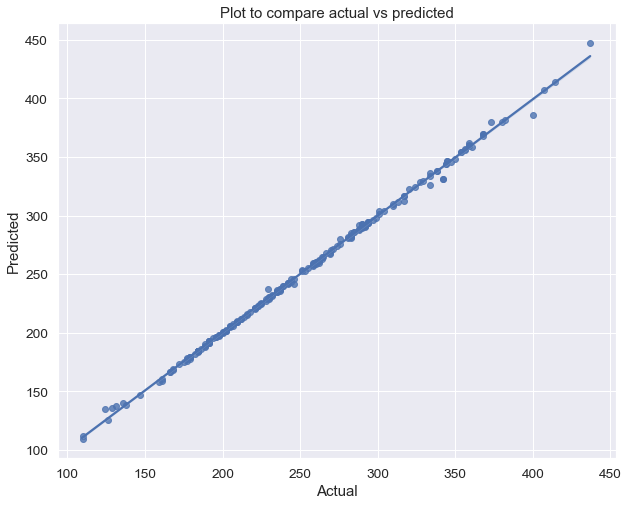

In [37]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [38]:
X.columns

Index(['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_CITY',
       'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB',
       'FUELCONSUMPTION_COMB_MPG', 'FUELTYPE_E', 'FUELTYPE_X', 'FUELTYPE_Z'],
      dtype='object')

In [39]:
xgbmodel.get_booster().feature_names = ['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_CITY',
       'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB',
       'FUELCONSUMPTION_COMB_MPG', 'FUELTYPE_E', 'FUELTYPE_X', 'FUELTYPE_Z']

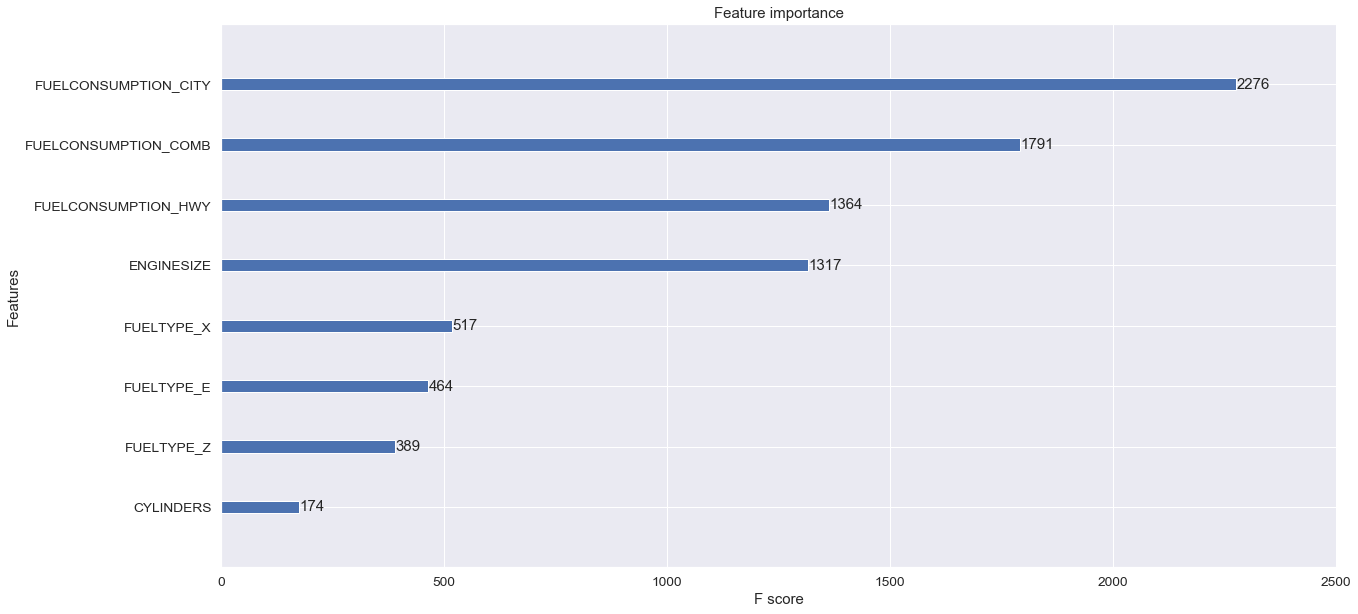

In [40]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

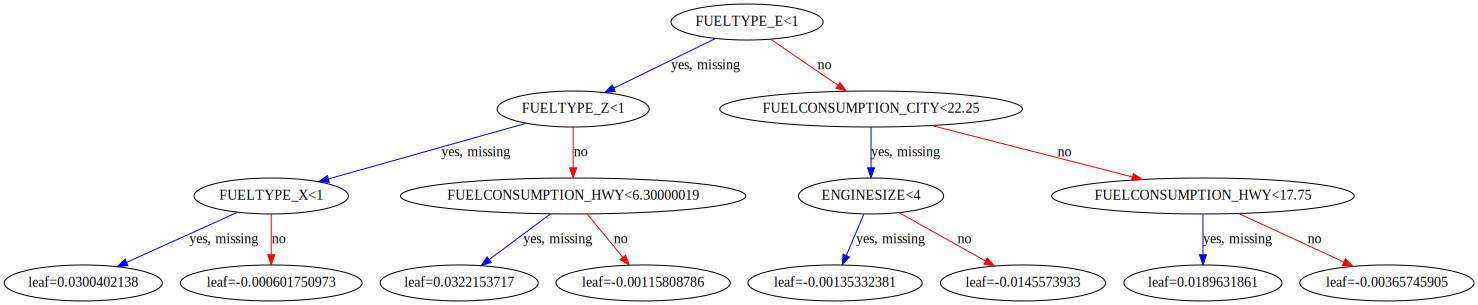

In [41]:
xgb.to_graphviz(xgbmodel,num_trees=1000)

### Cross-Validation

In [42]:
cv = cross_val_score(xgbmodel,X,y,cv=5,verbose=1,scoring='r2')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.8s finished


In [43]:
cv.mean()

0.99235259138642

### Feature Selection

### Model Prediction

### Model Tuning

### Using RandomSearchCV

In [44]:
model = XGBRegressor(random_state=0, n_estimators=1500, objective='reg:squarederror')

In [45]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [46]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, 
                           n_jobs=-1, scoring='r2')

In [47]:
randm.fit(X, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=1500,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=0, reg...
       34, 36, 38, 40, 42, 44, 46, 48]),
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                           

In [48]:
randm.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=22,
             importance_type='gain', learning rate=0.29, learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=500, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.5, verbosity=1)

In [49]:
randm.best_score_

0.9916401991117147

In [50]:
randm.best_params_

{'subsample': 0.5,
 'n_estimators': 500,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning rate': 0.29,
 'gamma': 22,
 'colsample_bytree': 0.5}

### Save the Model

In [53]:
import pickle
from pickle import dump
filename = 'fuelmodel.sav'
dump(xgbmodel,open(filename,'wb'))